### Sentiment Analysis for Tweets in Italian with **VADER**

In [59]:
from textblob import TextBlob
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import nltk
import re
import string

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

from PIL import Image, ImageFile
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display

ImageFile.LOAD_TRUNCATED_IMAGES = True

Auth is a method of authentification where the application makes API requests without the user context. Use this if you just need read-only access to publicly available information.  
First, you register the client application and acquire a consumer key and secret. Then, create an AppAuthHandler instance, passing in consumer key and secret.

In [60]:
# Authentication 

apiKey = 'xxx'
apiSecret = 'xxx'
accessToken = 'xxx'
accessTokenSecret = 'xxx'

auth = tweepy.OAuthHandler(apiKey, apiSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

## Getting tweets with keyword or hashtag

In [61]:
keyword = input('Enter keyword or hashtag to search: ') # enter keyword / hashtag(#) / user (@) to search  
noOfTweet = int(input('Enter how many tweets to analyze: ')) # enter number of tweets wanted

## Remember! ## 
tweepy.API allows to download only 200 tweets at a time. If you want to iterate, you need a **Cursor**  

In code:  
tweets = tweepy.Cursor(api.user_timeline, screen_name=user, count=200, tweet_mode='extended').items(lim)

In [62]:
#tweets = api.search_tweets(q=keyword, count=noOfTweet, tweet_mode='extended')

In [63]:
tweets = tweepy.Cursor(api.search_tweets, q=keyword, lang='it').items(noOfTweet)

In [64]:
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []

In [65]:
def percentage(part, whole):
    return 100*float(part)/float(whole)

In [66]:
positive = 0
negative = 0
neutral = 0
polarity = 0

for tweet in tweets:

    # print tweet text
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']

    polarity += analysis.sentiment.polarity

    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1 
    
    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1 

    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1
    
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

## Cleaning Tweets to analyse sentiment

In [67]:
# Number of Tweets (Total, Positive, Negative, Neutral)

tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)

print('total number: ', len(tweet_list))
print('positive number: ', len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ', len(neutral_list))

total number:  786
positive number:  155
negative number:  116
neutral number:  515


In [68]:
tweet_list

,0
0,RT @Rosam23_: con “I love you in every univers...
1,-10 gg per poter vedere \n\n#DoctorStrange \n#...
2,RT @_brynhildr_: HO APPENA REALIZZATO CHE COSA...
3,HO APPENA REALIZZATO CHE COSA MI RICORDAVA IL ...
4,Quella vena un po' Horror lo ha reso fantastic...
...,...
781,RT @LasOrozco: ¡Cosbaby!... Coleccionismo!!!.....
782,¡Cosbaby!... Coleccionismo!!!...\n\n#TikTok #h...
783,RT @Rosam23_: #DoctorStrange SPOILERS\n\n-\n\n...
784,Tremenda la peli #DoctorStrange 🥺🫶🏻


When looking at tweet_list we can easily see there are some duplicates.. we need to drop them

In [69]:
tweet_list.drop_duplicates(inplace=True)

In [70]:
tweet_list

,0
0,RT @Rosam23_: con “I love you in every univers...
1,-10 gg per poter vedere \n\n#DoctorStrange \n#...
2,RT @_brynhildr_: HO APPENA REALIZZATO CHE COSA...
3,HO APPENA REALIZZATO CHE COSA MI RICORDAVA IL ...
4,Quella vena un po' Horror lo ha reso fantastic...
...,...
778,"📣 Nuovo Podcast! ""68 - Non Solo Carta - Locura..."
781,RT @LasOrozco: ¡Cosbaby!... Coleccionismo!!!.....
782,¡Cosbaby!... Coleccionismo!!!...\n\n#TikTok #h...
784,Tremenda la peli #DoctorStrange 🥺🫶🏻


for the purpose of cleaning the dataset, we create a new df, and a new feature ('text'), clean text via lambda function and clean retweets (RT), link, punctuation characters and convert to lowercase

In [71]:
# creating the new df and feature
tw_list = pd.DataFrame(tweet_list)
tw_list['text'] = tw_list[0]

# removing RTs, punct, etc..
remove_rt = lambda x: re.sub('RT @\w+: ',"",x)
rt = lambda x: re.sub('(@[A-Za-z0-9]+) | ([0-9A-Za-z \t]) | (\w+:\/\/\S+)', "", x)

tw_list['text'] = tw_list.text.map(remove_rt).map(rt)
tw_list['text'] = tw_list.text.str.lower()

In [72]:
tw_list

,0,text
0,RT @Rosam23_: con “I love you in every univers...,con “i love you in every universe” la marvel c...
1,-10 gg per poter vedere \n\n#DoctorStrange \n#...,-10 gg per poter vedere \n\n#doctorstrange \n#...
2,RT @_brynhildr_: HO APPENA REALIZZATO CHE COSA...,ho appena realizzato che cosa mi ricordava il ...
3,HO APPENA REALIZZATO CHE COSA MI RICORDAVA IL ...,ho appena realizzato che cosa mi ricordava il ...
4,Quella vena un po' Horror lo ha reso fantastic...,quella vena un po' horror lo ha reso fantastic...
...,...,...
778,"📣 Nuovo Podcast! ""68 - Non Solo Carta - Locura...","📣 nuovo podcast! ""68 - non solo carta - locura..."
781,RT @LasOrozco: ¡Cosbaby!... Coleccionismo!!!.....,¡cosbaby!... coleccionismo!!!...\n\n#tiktok #h...
782,¡Cosbaby!... Coleccionismo!!!...\n\n#TikTok #h...,¡cosbaby!... coleccionismo!!!...\n\n#tiktok #h...
784,Tremenda la peli #DoctorStrange 🥺🫶🏻,tremenda la peli #doctorstrange 🥺🫶🏻


## Sentiment Analysis

We can now use cleaned text to compute polarity, subjectivity, sentiment parameters, and create new features into the df, for all computed parameters

In [73]:
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))

for index, row in tw_list['text'].iteritems():

    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']

    if neg > pos:
        tw_list.loc[index, 'sentiment'] = 'negative'
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = 'positive'
    else:
        tw_list.loc[index, 'sentiment'] = 'neutral'

    tw_list.loc[index, 'neg'] = neg
    tw_list.loc[index, 'pos'] = pos
    tw_list.loc[index, 'neu'] = neu
    tw_list.loc[index, 'compound'] = comp

In [74]:
tw_list

,0,text,polarity,subjectivity,sentiment,neg,pos,neu,compound
0,RT @Rosam23_: con “I love you in every univers...,con “i love you in every universe” la marvel c...,0.50,0.60,positive,0.000,0.356,0.644,0.8555
1,-10 gg per poter vedere \n\n#DoctorStrange \n#...,-10 gg per poter vedere \n\n#doctorstrange \n#...,0.00,0.00,positive,0.000,0.268,0.732,0.2960
2,RT @_brynhildr_: HO APPENA REALIZZATO CHE COSA...,ho appena realizzato che cosa mi ricordava il ...,-0.05,0.15,negative,0.122,0.000,0.878,-0.2023
3,HO APPENA REALIZZATO CHE COSA MI RICORDAVA IL ...,ho appena realizzato che cosa mi ricordava il ...,-0.05,0.15,negative,0.122,0.000,0.878,-0.2023
4,Quella vena un po' Horror lo ha reso fantastic...,quella vena un po' horror lo ha reso fantastic...,0.00,0.00,negative,0.303,0.158,0.539,-0.6705
...,...,...,...,...,...,...,...,...,...
778,"📣 Nuovo Podcast! ""68 - Non Solo Carta - Locura...","📣 nuovo podcast! ""68 - non solo carta - locura...",-0.05,0.15,negative,0.139,0.000,0.861,-0.2714
781,RT @LasOrozco: ¡Cosbaby!... Coleccionismo!!!.....,¡cosbaby!... coleccionismo!!!...\n\n#tiktok #h...,0.00,0.00,neutral,0.000,0.000,1.000,0.0000
782,¡Cosbaby!... Coleccionismo!!!...\n\n#TikTok #h...,¡cosbaby!... coleccionismo!!!...\n\n#tiktok #h...,0.00,0.00,neutral,0.000,0.000,1.000,0.0000
784,Tremenda la peli #DoctorStrange 🥺🫶🏻,tremenda la peli #doctorstrange 🥺🫶🏻,0.00,0.00,neutral,0.000,0.000,1.000,0.0000


Split the dataframe in three groups based on sentiment

In [75]:
tw_list_negative = tw_list[tw_list['sentiment']=='negative']
tw_list_positive = tw_list[tw_list['sentiment']=='positive']
tw_list_neutral = tw_list[tw_list['sentiment']=='neutral']

In [76]:
# count values for sentiment features and see total percentage

def count_values_in_col(data, feature):

    total = data.loc[:, feature].value_counts(dropna=False)

    percentage = round(data.loc[:, feature].value_counts(dropna=False, normalize=True)*100,2)

    return pd.concat([total, percentage], axis=1, keys=['Total', 'Percentage'])

In [77]:
pc=count_values_in_col(tw_list, 'sentiment')

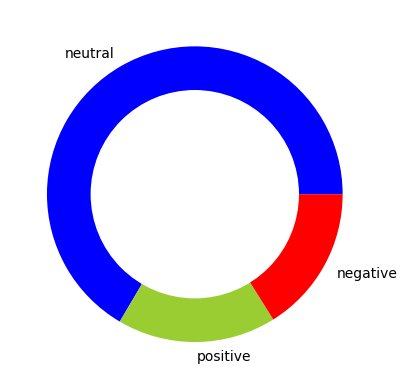

In [78]:
# create a chart using number of sentiment tweets

pichart = count_values_in_col(tw_list, 'sentiment')
names = pc.index
size = pc['Percentage']

# create a circle for the center of the plot

my_circle = plt.Circle( (0,0), 0.7, color = 'white')
plt.pie(size, labels=names, colors=['blue', 'yellowgreen', 'red'])
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [79]:
# function to create a wordcloud

def create_wordcloud(text):

    img = Image.new('RGBA', size=(500, 500), color=(255, 0, 0, 0))
    img.save('wc.png', 'PNG')

    mask = np.array(Image.open('wc.png'))
    stopwords = set(STOPWORDS)

    wc = WordCloud(background_color='white', mask = mask, max_words=3000, stopwords=stopwords,repeat=True)
    wc.generate(str(text))
    wc.to_file('wc.png')
    print('Word Cloud Saved Successfully')
    path='wc.png'
    display(Image.open(path))

Word Cloud Saved Successfully


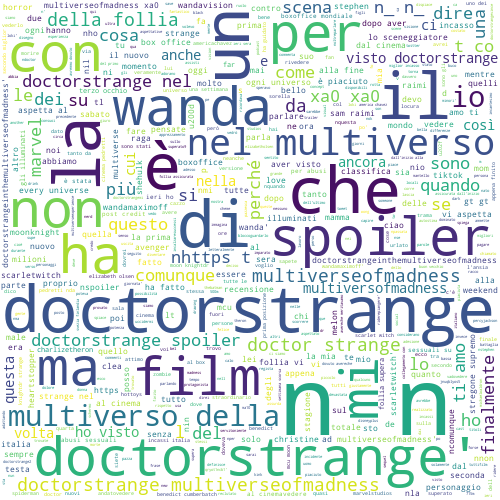

In [80]:
# wordcloud for all tweets
create_wordcloud(tw_list['text'].values)

Word Cloud Saved Successfully


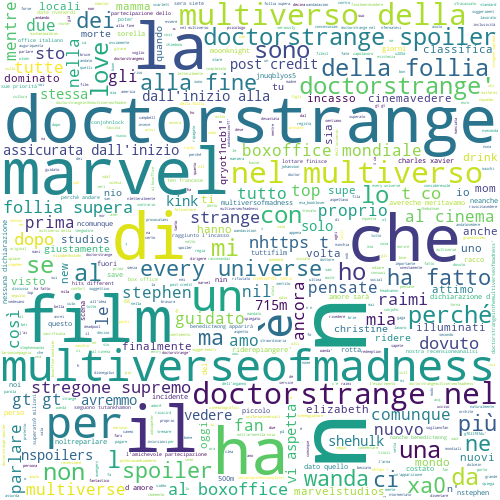

In [81]:
# wordcloud for positive sentiment
create_wordcloud(tw_list_positive['text'].values)

Word Cloud Saved Successfully


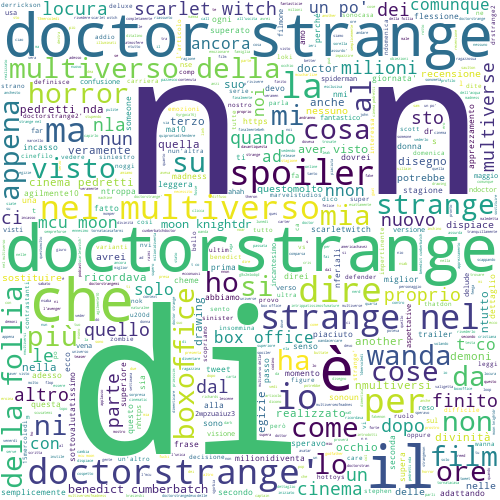

In [82]:
# wordcloud for negative sentiment
create_wordcloud(tw_list_negative['text'].values)

In [83]:
# computing tweet's length and word count

tw_list['text_len'] = tw_list['text'].astype(str).apply(len)

tw_list['text_word_count'] = tw_list['text'].apply(lambda x: len(str(x).split()))

round(pd.DataFrame(tw_list.groupby('sentiment').text_len.mean()), 2)

,text_len
sentiment,
negative,101.81
neutral,94.24
positive,110.59


Applying **count vectorizer** provides the capability to preprocess your text data prior to generating the vector representation making it a highly flexible feature representation module for text.  
After count vectorizer, it is possible to analyze the words with two or three or whatever n-grams you want.  
Applying **stemmer** also provides the root of the words, so that we can eliminate words coming from the same root. If we apply the stemmer function, we can consider those words all the same. 

In [84]:
# remove punctuation

def remove_punct(text):

    text = "".join([char for char in text if char not in string.punctuation])

    text = re.sub('[0-9]+', '', text)

    return text

tw_list['punct'] = tw_list['text'].apply(lambda x: remove_punct(x))

In [85]:
#Appliyng tokenization
def tokenization(text):
    text = re.split('\W+', text)
    return text

tw_list['tokenized'] = tw_list['punct'].apply(lambda x: tokenization(x.lower()))

In [86]:
# nltk.download('stopwords')

In [87]:
#Removing stopwords
stopword = nltk.corpus.stopwords.words('english')
def remove_stopwords(text):
    text = [word for word in text if word not in stopword]
    return text
    
tw_list['nonstop'] = tw_list['tokenized'].apply(lambda x: remove_stopwords(x))

In [88]:
#Appliyng Stemmer
ps = nltk.PorterStemmer()

def stemming(text):
    text = [ps.stem(word) for word in text]
    return text

tw_list['stemmed'] = tw_list['nonstop'].apply(lambda x: stemming(x))

In [89]:
#Cleaning Text

def clean_text(text):

    text_lc = "".join([word.lower() for word in text if word not in string.punctuation]) # remove puntuation
    text_rc = re.sub('[0-9]+', '', text_lc)
    tokens = re.split('\W+', text_rc)    # tokenization
    text = [ps.stem(word) for word in tokens if word not in stopword]  # remove stopwords and stemming
    
    return text
    
tw_list.head(10)

,0,text,polarity,subjectivity,sentiment,neg,pos,neu,compound,text_len,text_word_count,punct,tokenized,nonstop,stemmed
0,RT @Rosam23_: con “I love you in every univers...,con “i love you in every universe” la marvel c...,0.50,0.60,positive,0.000,0.356,0.644,0.8555,120,20,con “i love you in every universe” la marvel c...,"[con, i, love, you, in, every, universe, la, m...","[con, love, every, universe, la, marvel, ci, h...","[con, love, everi, univers, la, marvel, ci, ha..."
1,-10 gg per poter vedere \n\n#DoctorStrange \n#...,-10 gg per poter vedere \n\n#doctorstrange \n#...,0.00,0.00,positive,0.000,0.268,0.732,0.2960,80,7,gg per poter vedere \n\ndoctorstrange \ndocto...,"[, gg, per, poter, vedere, doctorstrange, doct...","[, gg, per, poter, vedere, doctorstrange, doct...","[, gg, per, poter, veder, doctorstrang, doctor..."
2,RT @_brynhildr_: HO APPENA REALIZZATO CHE COSA...,ho appena realizzato che cosa mi ricordava il ...,-0.05,0.15,negative,0.122,0.000,0.878,-0.2023,92,14,ho appena realizzato che cosa mi ricordava il ...,"[ho, appena, realizzato, che, cosa, mi, ricord...","[ho, appena, realizzato, che, cosa, mi, ricord...","[ho, appena, realizzato, che, cosa, mi, ricord..."
3,HO APPENA REALIZZATO CHE COSA MI RICORDAVA IL ...,ho appena realizzato che cosa mi ricordava il ...,-0.05,0.15,negative,0.122,0.000,0.878,-0.2023,92,14,ho appena realizzato che cosa mi ricordava il ...,"[ho, appena, realizzato, che, cosa, mi, ricord...","[ho, appena, realizzato, che, cosa, mi, ricord...","[ho, appena, realizzato, che, cosa, mi, ricord..."
4,Quella vena un po' Horror lo ha reso fantastic...,quella vena un po' horror lo ha reso fantastic...,0.00,0.00,negative,0.303,0.158,0.539,-0.6705,104,17,quella vena un po horror lo ha reso fantastico...,"[quella, vena, un, po, horror, lo, ha, reso, f...","[quella, vena, un, po, horror, lo, ha, reso, f...","[quella, vena, un, po, horror, lo, ha, reso, f..."
5,#DoctorStrange #MultiverseOfMadness mantiene l...,#doctorstrange #multiverseofmadness mantiene l...,0.00,0.00,neutral,0.000,0.000,1.000,0.0000,115,12,doctorstrange multiverseofmadness mantiene la ...,"[doctorstrange, multiverseofmadness, mantiene,...","[doctorstrange, multiverseofmadness, mantiene,...","[doctorstrang, multiverseofmad, mantien, la, p..."
6,RT @theWiseMag_: L’adesione di #svezia e #finl...,"l’adesione di #svezia#finlandia alla #nato, un...",0.00,0.00,neutral,0.000,0.000,1.000,0.0000,116,13,l’adesione di sveziafinlandia alla nato un’int...,"[l, adesione, di, sveziafinlandia, alla, nato,...","[l, adesione, di, sveziafinlandia, alla, nato,...","[l, adesion, di, sveziafinlandia, alla, nato, ..."
7,Box Office Usa\nDoctor Strange Verso $ 300 Mil...,box office usa\ndoctor strange verso $ 300 mil...,-0.05,0.15,negative,0.101,0.000,0.899,-0.2023,110,19,box office usa\ndoctor strange verso milioni...,"[box, office, usa, doctor, strange, verso, mil...","[box, office, usa, doctor, strange, verso, mil...","[box, offic, usa, doctor, strang, verso, milio..."
8,RT @cumberbatch_ita: “I love you in every Univ...,“i love you in every universe”… nessuna dichia...,0.50,0.60,positive,0.000,0.244,0.756,0.6369,119,14,“i love you in every universe”… nessuna dichia...,"[, i, love, you, in, every, universe, nessuna,...","[, love, every, universe, nessuna, dichiarazio...","[, love, everi, univers, nessuna, dichiarazion..."
9,"¡¡CORRE PERRA, CORRE!! \n\n#DoctorStrange #Mul...","¡¡corre perra, corre!! \n\n#doctorstrange #mul...",0.00,0.00,neutral,0.000,0.000,1.000,0.0000,74,6,¡¡corre perra corre \n\ndoctorstrange multiver...,"[, corre, perra, corre, doctorstrange, multive...","[, corre, perra, corre, doctorstrange, multive...","[, corr, perra, corr, doctorstrang, multiverse..."


Now, you can apply coun vectorizer the see all unique words as a new features

In [90]:
#Appliyng Countvectorizer
countVectorizer = CountVectorizer(analyzer=clean_text) 
countVector = countVectorizer.fit_transform(tw_list['text'])
print('{} Number of reviews has {} words'.format(countVector.shape[0], countVector.shape[1]))

466 Number of reviews has 1669 words


In [91]:
print(countVectorizer.get_feature_names_out())

['' 'abbia' 'abbiamo' ... 'zombiestrang' 'è' 'é']


In [92]:
count_vect_df = pd.DataFrame(countVector.toarray(), columns=countVectorizer.get_feature_names())
count_vect_df.head()

c:\Users\Dylan\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,,abbia,abbiamo,abusi,accompagnar,acq,acquist,ad,adattando,addio,...,wong,wongdel,xavier,xxxhscxxx,zara,zaraphytian,zombi,zombiestrang,è,é
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


You can sort values as a descending to see most used words

In [93]:
# Most Used Words
count = pd.DataFrame(count_vect_df.sum())
countdf = count.sort_values(0,ascending=False).head(20)
countdf[1:11]

,0
,295
di,157
che,104
il,91
è,90
la,87
spoiler,80
multiverseofmad,78
un,69
per,61


Building **N-GRAMS** Models helps to predict most probably word that might follow this sequence.

In [94]:
#Function to ngram
def get_top_n_gram(corpus,ngram_range,n=None):
 vec = CountVectorizer(ngram_range=ngram_range,stop_words = 'english').fit(corpus)
 bag_of_words = vec.transform(corpus)
 sum_words = bag_of_words.sum(axis=0) 
 words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
 words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
 return words_freq[:n]

In [95]:
#n2_bigram

n2_bigrams = get_top_n_gram(tw_list['text'],(2,2),20)
n2_bigrams

[('doctorstrange multiverseofmadness', 46),
 ('nel multiverso', 35),
 ('multiverso della', 35),
 ('della follia', 32),
 ('doctor strange', 28),
 ('doctorstrange nel', 26),
 ('multiverseofmadness doctorstrange', 25),
 ('doctorstrange spoilers', 22),
 ('di doctorstrange', 18),
 ('ti amo', 16),
 ('spoiler doctorstrange', 15),
 ('visto doctorstrange', 13),
 ('ho visto', 12),
 ('doctorstrange doctorstrangeinthemultiverseofmadness', 11),
 ('strange nel', 10),
 ('sam raimi', 10),
 ('al cinema', 10),
 ('doctorstrange lo', 10),
 ('lo sceneggiatore', 10),
 ('la prima', 9)]

In [96]:
#n3_trigram

n3_trigrams = get_top_n_gram(tw_list['text'],(3,3),20)
n3_trigrams

[('nel multiverso della', 35),
 ('multiverso della follia', 32),
 ('doctorstrange nel multiverso', 26),
 ('doctorstrange lo sceneggiatore', 10),
 ('doctor strange nel', 9),
 ('strange nel multiverso', 9),
 ('ti amo ogni', 9),
 ('amo ogni universo', 9),
 ('spoiler doctorstrange multiverseofmadness', 8),
 ('della follia vi', 8),
 ('follia vi aspetta', 7),
 ('di doctor strange', 6),
 ('il nuovo doctorstrange', 6),
 ('dopo aver visto', 6),
 ('doctorstrange multiverseofmadness ha', 6),
 ('vi aspetta al', 6),
 ('ho visto doctorstrange', 5),
 ('ti amo ti', 5),
 ('amo ti amo', 5),
 ('aspetta al cinema', 5)]